In [93]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import torch
from torchtrainer.models.resunet import ResUNet
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from torchtrainer import transforms

In [92]:
unet = UNet(3, 2)
hooks_act = Hooks(unet, [unet.l1_, unet.l2_, unet.l3_, unet.l4_], calculate_stats(True))
hooks_wei = Hooks(unet, [unet.l1_.dconv[0], unet.l2_.dconv[0], unet.l3_.dconv[0], unet.l4_.dconv[0]], 
                  calculate_stats(False, True))

xb = torch.randn([2, 3, 128, 128])
pred = unet(xb)

NameError: name 'UNet' is not defined

In [95]:
model = ResUNet(num_channels=1, num_classes=2) 
checkpoint = torch.load(r'E:\Dropbox\ufscar\Baptiste\Astrocytes\codes\learner_vessel.tar')
model.load_state_dict(checkpoint['model_state'])
model.eval();
#model.to('cuda');

In [96]:
file = r'E:\Dropbox\ufscar\Baptiste\Astrocytes\data\Astrocytes project\vessels\2D analysis astrocytes - vessels samples\whole\P0\P0@20x@Animal 1@1_1_1@1_1_1_CD31.tif'
img = torch.tensor(np.array((Image.open(file))))[None]

imgaug_seq = iaa.Sequential([
    iaa.CLAHE(clip_limit=6, tile_grid_size_px=12)
])    
imgaug_seq = transforms.translate_imagaug_seq(imgaug_seq)
valid_transforms = [transforms.TransfToImgaug(), imgaug_seq, transforms.TransfToTensor(), 
                    transforms.TransfWhitten(67.576, 37.556)]
for t in valid_transforms:
    img = t(img)

with torch.no_grad():
    pred = model(img[None].float())[0]

<IPython.core.display.Javascript object>


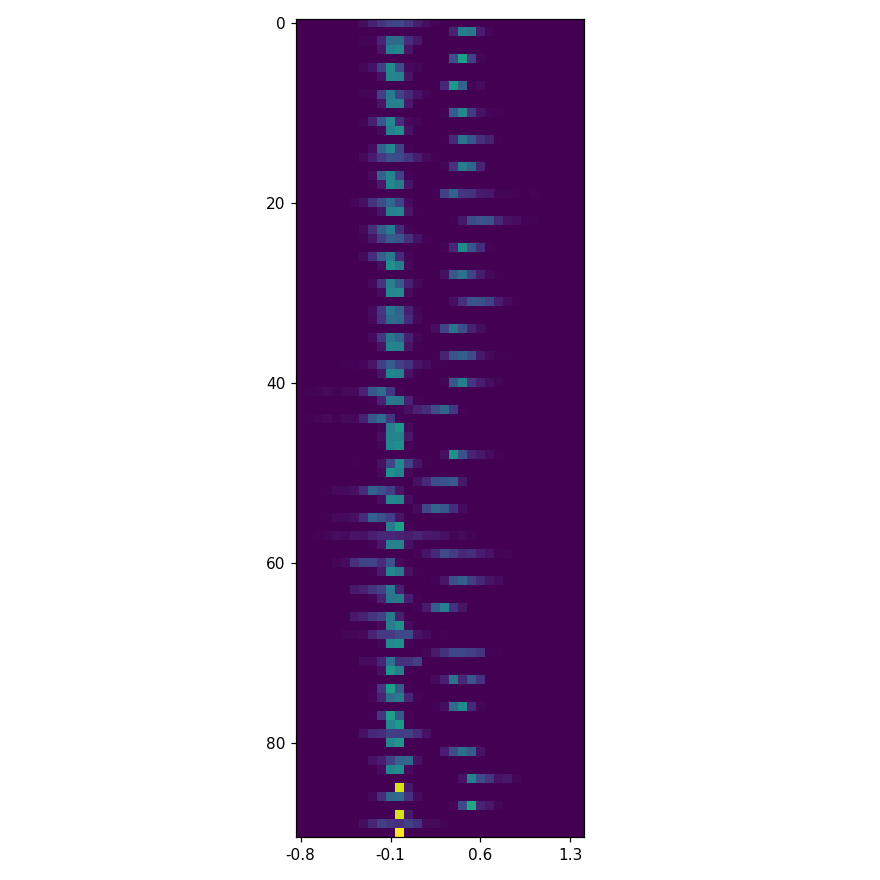

E:\Miniconda3\lib\site-packages\ipykernel_launcher.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator


In [242]:
%matplotlib notebook

def get_parameters_bounds(model):

    par_min_all = 10e10
    par_max_all = -10e10
    with torch.no_grad():
        for par_name, par in model.named_parameters():
            par_min, par_max = par.min(), par.max()
            if par_min<par_min_all:
                par_min_all = par_min
            if par_max>par_max_all:
                par_max_all = par_max
                
    return par_min_all, par_max_all

def parameters_histograms(model, nbins=32, per_channel=False, range=None, use_global_range=True):
    
    if range is not None and use_global_range:
        print("Warning, when `use_global_range` is True, `range` should not be provided. Using provided range.")
    
    include_outliers = False
    if range is None:
        if use_global_range:
            min, max = get_parameters_bounds(model)
        else:
            min = max = 0
    else:
        min, max = range
        include_outliers = True
    
    hists = {}
    with torch.no_grad():
        for par_name, par in model.named_parameters():
            if par.ndim<=1 or not per_channel:
                hist, bins = _calc_par_histogram(par, nbins, min, max, include_outliers)
                hists[par_name] = [{'hist':hist, 'bins':bins}]
            else:
                hists[par_name] = []
                for par_channel in par:
                    hist, bins = _calc_par_histogram(par_channel, nbins, min, max, include_outliers)
                    hists[par_name].append({'hist':hist, 'bins':bins})
        
    return hists

def _calc_par_histogram(parameter, nbins, min, max, include_outliers):

    if min==0 and max==0:
        min, max = parameter.min(), parameter.max()
    bins = torch.linspace(min, max, nbins)
    hist = torch.histc(parameter, bins=nbins, min=min, max=max)
    if include_outliers:
        num_below = torch.sum(parameter<min)
        num_above = torch.sum(parameter>max)
        bins = torch.cat((torch.tensor([-10e15]), bins, torch.tensor([10e15])))
        hist = torch.cat((torch.tensor([num_below]), hist, torch.tensor([num_above])))
    hist = hist/parameter.numel()
        
    return hist, bins
    
def create_hist_image(hists, ax=None):
    
    k = list(hists.keys())
    nbins = len(hists[k[0]][0]['hist'])
    num_hists = 0
    for par_hists in hists.values():
        num_hists += len(par_hists)
    hist_img = torch.zeros((num_hists, nbins))
    idx = 0
    for param_name, par_hists in hists.items():
        for par_hist in par_hists:
            hist, bins = par_hist['hist'], par_hist['bins']
            hist_img[idx] = hist
            idx += 1

    if ax is None:
        fig = plt.figure(figsize=[8, 8])
        ax = fig.add_subplot(111, aspect='equal')
    ax.imshow(hist_img)
    locs = ax.get_xticks()
    labels = []
    for loc in locs:
        if loc>=0 and loc<bins.numel():
            labels.append(f'{bins[round(loc)].item():.1f}')
    ax.set_xticklabels(labels)

nbins = 32
per_channel = False
hists = parameters_histograms(model, nbins=32, per_channel=False, use_global_range=True)
create_hist_image(hists)
plt.tight_layout()

In [237]:
debug

> <ipython-input-236-92a8d1d8c634>(72)create_hist_image()
     70     for param_name, par_hists in enumerate(hists.items()):
     71         for par_hist in par_hists:
---> 72             hist, bins = par_hist['hist'], par_hist['bins']
     73             hist_img[idx] = hist
     74             idx += 1

ipdb> par_hists
('encoder.conv1.weight', [{'hist': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0204, 0.0204, 0.0612,
        0.2041, 0.2245, 0.0816, 0.2041, 0.1224, 0.0612, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), 'bins': tensor([-1.4922, -1.3528, -1.2134, -1.0739, -0.9345, -0.7951, -0.6557, -0.5163,
        -0.3768, -0.2374, -0.0980,  0.0414,  0.1809,  0.3203,  0.4597,  0.5991,
         0.7386,  0.8780,  1.0174,  1.1568,  1.2962,  1.4357,  1.5751,  1.7145,
         1.8539,  1.9934,  2.1328,  2.2722,  2.4116,  2.5511,  2.6905,  2.8299])}, {'hist': tensor([0.00

ipdb> param_name
0
ipdb> q


In [205]:
ax.set_xticklabels

array([-10.,   0.,  10.,  20.,  30.,  40.])

array([-10.,   0.,  10.,  20.,  30.,  40.])